In [1]:
import cortex
import cortex.polyutils
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import os
opj = os.path.join
import plotly.io as pio
import cortex
import seaborn as sns
import pickle
from importlib import reload

In [2]:
subjectid=['sub-46']
subject = subjectid
atlas = 'manual'
model_name='nelder-mead'
space='fsnative'
source='V1'
target_list=['V2','V3', 'V4']
use_venousmask=False
LOconcat=False
fssubject = 'fsnative'
project='PROJECT_EGRET-AAA'
denoising='nordic'
MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives'
fs_dirPATH=f'{MAIN_PATH}/freesurfer' 
hemi=['RH','LH']
rois_list = np.array([['V1','V2', 'V3', 'V4'], [1, 2, 3, 4]])
rois = [['V1','V2', 'V3']]
depth_list=['GM']
pred_point=2

In [3]:
def load_CF_params(subject, denoising, atlas, model_name, depth_list,rois_list, source, target_list,target):
    best_fit=[]
    tc=[]
    thickness=[]
    pred_tc=[]

    roi_name=rois[0][target]
    roi_idx = np.where(roi_name == rois_list[0, :])
    target_idx=np.where(rois_list[0]==target_list[target])
    target=rois_list[0][target_idx][0]
    try:
        best_fit_prf_lh = f'{MAIN_PATH}/CFM/{subject}/ses-1/GM/lh/{target}-{source}/best_fits_prf.csv'
        
        #best_fit_prf_lh = f'/Volumes/FedericaCardillo/results/{subject}/lh/{target}-{source}/best_fits_prf.csv'
        best_fit_prf_lh=pd.read_csv(best_fit_prf_lh)
    except:
        best_fit_prf_lh=pd.DataFrame([])
    try:
        best_fit_prf_rh = f'{MAIN_PATH}/CFM/{subject}/ses-1/GM/rh/{target}-{source}/best_fits_prf.csv'
        #best_fit_prf_rh = f'/Volumes/FedericaCardillo/results/{subject}/rh/{target}-{source}/best_fits_prf.csv'
        best_fit_prf_rh=pd.read_csv(best_fit_prf_rh)
    except:
        best_fit_prf_rh=pd.DataFrame([])

    best_fit_prf=pd.concat([best_fit_prf_lh,best_fit_prf_rh])
    best_fit.append(best_fit_prf)

    return best_fit

In [4]:
class CFmodel:
    def __init__(self, r2, CFsize, CFcenter_ecc, CFcenter_angle, depth,fs_idx, venous_mask):
        self.r2 = r2
        self.CFsize = CFsize
        self.CFcenter_ecc = CFcenter_ecc
        self.CFcenter_angle = CFcenter_angle
        self.depth = depth
        self.fs_idx = fs_idx
        self.venous_mask=venous_mask

In [5]:
class ROI:
    def __init__(self, roi_name, CFmodel, curve, curve_up, curve_low):
        self.roi_name=roi_name
        self.CFmodel=CFmodel
        self.curve=curve
        self.curve_up=curve_up
        self.curve_low=curve_low

In [6]:
def load_CFmodels(best_fit, depth_list,use_venousmask=False):
    CFmodels = []

    for d in range(depth_list.__len__()):
        CFmdl = CFmodel([],[],[],[],[],[],[])
        CFmdl.CFcenter_ecc = best_fit[0]['Source Eccentricity'].values
        CFmdl.CFcenter_angle = best_fit[0]['Source Polar Angle'].values
        CFmdl.CFsize = best_fit[0]['Best Sigma Finer'].values
        CFmdl.r2 = best_fit[0]['Best Variance Explained Finer'].values
        CFmdl.depth = depth_list[d]
        CFmdl.fs_idx = best_fit[0]['Target Vertex Index'].values
        if use_venousmask==True:
            pkl_file=opj(f'{MAIN_PATH}/venous_mask/{subject[s]}/ses-02/', f'{subject[s]}_desc-{depth_list[d]}_venous_mask.pkl')
            with open(pkl_file, 'rb') as input:
                pkl_data = pickle.load(input)
                venous_mask=pkl_data['venous_mask']
        else:
            venous_mask=np.ones_like(CFmdl.r2)
        CFmdl.venous_mask = venous_mask

        CFmodels.append(CFmdl)
    return CFmodels

In [7]:
def load_rois(subject, atlas):
    surfs = [cortex.polyutils.Surface(*d)for d in cortex.db.get_surf(subject, "fiducial")]
    idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subject, label='benson14_varea-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
    
    if atlas=='manual':
        idx_rois5, idx_vls5 = cortex.freesurfer.get_label(subject, label='manualdelin', fs_dir=fs_dirPATH, hemisphere=('lh','rh'), verbose=True)
        idx_vls4[idx_rois5]=idx_vls5
    
    return idx_vls4

In [8]:
class sub:
    def __init__(self,subject, denoising, atlas, model_name, depth_list, rois_list,source,target_list,use_venousmask=False):
        self.rois=[]
        idx_vls4=load_rois(subject,atlas) 
        for target in range(target_list.__len__()):
            best_fit=load_CF_params(subject,denoising,atlas,model_name,depth_list,rois_list, source, target_list,target)
            CFmodels=load_CFmodels(best_fit,depth_list,use_venousmask)
            roi=ROI(target_list[target],CFmodels,np.zeros((len(depth_list),)),np.zeros((len(depth_list),)),np.zeros((len(depth_list),)))

            for d in range(depth_list.__len__()):
                CFmodels[d].CFcenter_ecc, CFmodels[d].CFcenter_angle, CFmodels[d].CFsize, CFmodels[d].r2, CFmodels[d].fs_idx, CFmodels[d].venous_mask= \
                    [x for x in (CFmodels[d].CFcenter_ecc, CFmodels[d].CFcenter_angle, CFmodels[d].CFsize, CFmodels[d].r2,CFmodels[d].fs_idx, CFmodels[d].venous_mask)]
            self.rois.append(roi)

In [9]:
def mask_CFmodel(CFmodel,depth_list, r2_threshold, ecc_bound, CFsize_bound):
    
    for d in range(depth_list.__len__()):
        idx_thr=np.ones_like(CFmodel[d].CFcenter_ecc, dtype=bool)
        idx_ecc1=CFmodel[d].CFcenter_ecc>ecc_bound[0]
        idx_ecc2=CFmodel[d].CFcenter_ecc<ecc_bound[1]
        idx_size1=CFmodel[d].CFsize>CFsize_bound[0]
        idx_r2=CFmodel[d].r2>=r2_threshold
        venous_mask=CFmodel[d].venous_mask>0
        idx_thr &= idx_ecc1 & idx_ecc2 & idx_size1 & idx_r2 & venous_mask
        CFmodel[d].CFcenter_ecc, CFmodel[d].CFcenter_angle,CFmodel[d].CFsize, CFmodel[d].r2,CFmodel[d].fs_idx,CFmodel[d].venous_mask = \
            [x[idx_thr] for x in (CFmodel[d].CFcenter_ecc, CFmodel[d].CFcenter_angle, CFmodel[d].CFsize, CFmodel[d].r2, CFmodel[d].fs_idx,CFmodel[d].venous_mask)]
    return CFmodel

In [10]:
SUBJECTS=[[] for s in range(subject.__len__())]
for s in range(subject.__len__()):
    SUBJECTS[s]=sub(subject[s],denoising,atlas,model_name,depth_list,rois_list, source, target_list, use_venousmask)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/pycortex'

# Concatenate LO-1 and LO-2, if desired

In [ ]:
from numpy.polynomial import Polynomial
set_q3=0
r2_thr=0.3
ecc_bound=[0.1, 7]
CFsize_bound=[0.1,2.5]

In [ ]:
def bs_scatter2weightedavg(x,y,r2,N, cf, ecc_bound, x_pred_point=None): #N: number of bootstrapped samples, cf: confidence level
    sns.set_palette('bright')  # Use 'mako' color palette from Seaborn
    sns.set_style('white')  # Set the style with grid
    colors=sns.color_palette()
    bs_beta, bs_a=[], []
    indices = np.argsort(x) #reorder elements of x in ascending order
    x, y, r2 =x[indices], y[indices], r2[indices]
    x_fit = np.linspace(ecc_bound[0],ecc_bound[1],len(x)) # Points for new predictions
    y_fit = np.zeros((N, len(x_fit))) # Initialize a matrix to store predictions for each point in x_fit, for each bootstrapped slope
    if x_pred_point is not None:
        y_pred, y_pred_low, y_pred_up=np.zeros((N)),[],[] # Initialize a matrix to store predictions for specific point, for each bootstrapped slope

    plt.scatter(x, y, alpha=r2, marker='o')#, color=colors[1])

    for i in range(N):
        rnd_idx = np.random.choice(len(x), size=len(x), replace=True)
        res_x, res_y, res_r2 = x[rnd_idx], y[rnd_idx], r2[rnd_idx]
        model = np.polyfit(res_x, res_y, deg=1, w=res_r2)
        bs_beta.append(model[0])
        bs_a.append(model[1])
        # plot each estimated line:
        y_line = model[0] * x_fit + model[1]
        y_fit[i, :] = model[0] * x_fit + model[1]
        if x_pred_point is not None:
            y_pred[i] = model[0] * x_pred_point + model[1]
        #plt.plot(x_fit, y_line, ls='dashed', linewidth=0.05, alpha=0.05,color='b')
        #plt.plot(x_fit, y_fit[i,:], ls='dashed', linewidth=0.05, alpha=0.05,color='b')

    bs_w_model=[np.mean(bs_beta), np.mean(bs_a)] #mean bootstrapped slope parameters
    y_line=bs_w_model[0]*x_fit+bs_w_model[1] #mean bootstrapped slope
    plt.plot(x_fit,y_line, ls='solid', linewidth=1, alpha=0.9)#,color='b') #plot mean bootstrapped slope

    # Compute the percentiles for confidence intervals for bootstrapped slope
    lower_bounds = np.percentile(y_fit, 2.5, axis=0)
    upper_bounds = np.percentile(y_fit, 97.5, axis=0)

    if x_pred_point is not None:
        # Compute the percentiles for confidence intervals for specific point
        y_pred_mean=bs_w_model[0]*x_pred_point+bs_w_model[1]
        y_pred_low = np.percentile(y_pred, 2.5, axis=0)
        y_pred_up = np.percentile(y_pred, 97.5, axis=0)

    lower_percentile = (1 - cf) / 2 * 100
    upper_percentile = (cf + (1 - cf) / 2) * 100
    ci = [np.percentile(bs_beta, [lower_percentile, upper_percentile]), np.percentile(bs_a, [lower_percentile, upper_percentile])]
    bs_w_model_low=[ci[0][0], ci[1][0]]
    y_line_low=ci[0][0]*x_fit+ci[1][0]
    bs_w_model_up=[ci[0][1], ci[1][1]]
    y_line_up=ci[0][1]*x_fit+ci[1][1]
    #Fill between the lines to create shaded area
   # plt.fill_between(x_fit, y_line_low, y_line_up, color='gray', alpha=0.1)#, label=f'CI: {cf*100}%')
    plt.fill_between(x_fit, lower_bounds, upper_bounds, color='gray', alpha=0.2)#, label=f'CI: {cf*100}%')

    if x_pred_point is not None:
        #return bs_w_model, bs_w_model_low, bs_w_model_up
        return y_pred_mean, y_pred_low, y_pred_up
    else:
        return
 
def dag_add_ax_basics(ax, **kwargs):    
    '''dag_add_ax_basics
    Description:
        Add basic features to a plot
        
    Input:
        ax              matplotlib axes
        *Optional*
        xlabel          str             x axis label
        ylabel          str             y axis label
        title           str             title
        x_lim           tuple           x axis limits
        y_lim           tuple           y axis limits
    Return:
        None
    '''    
    xlabel = kwargs.get("xlabel", None)
    ylabel = kwargs.get("ylabel", None)
    title = kwargs.get("title", None)
    x_lim = kwargs.get("x_lim", None)
    y_lim = kwargs.get("y_lim", None)
    despine = kwargs.get('despine', True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)    
    # ax.legend()
    if despine:
        if 'right' in ax.spines.keys():
            ax.spines['right'].set_visible(False)
        if 'top' in ax.spines.keys():
            ax.spines['top'].set_visible(False)

def dag_update_ax_fontsize(ax, new_font_size, include=None, do_extra_search=True):
    '''dag_update_ax_fontsize
    Description:
        Update the font size of am axes
    Input:
        ax              matplotlib axes
        new_font_size   int/float
        *Optional*
        include         list of strings     What to update the font size of. 
                                            Options are: 'title', 'xlabel', 'ylabel', 'xticks','yticks'
        do_extra_search bool                Whether to search through the children of the axes, and update the font size of any text
    Return:
        None        
    '''
    if include is None: # If no include is specified, update all the text       
        include = ['title', 'xlabel', 'ylabel', 'xticks','yticks']
    if not isinstance(include, list): # If include is not a list, make it a list
        include = [include]
    incl_list = []
    for i in include: # Loop through the include list, and add the relevant text to the list
        if i=='title': 
            incl_list += [ax.title]
        elif i=='xlabel':
            incl_list += [ax.xaxis.label]
        elif i=='ylabel':
            incl_list += [ax.yaxis.label]
        elif i=='xticks':
            incl_list += ax.get_xticklabels()
        elif i=='yticks':
            incl_list += ax.get_yticklabels()
        elif i=='legend':
            incl_list += ax.get_legend().get_texts()

    for item in (incl_list): # Loop through the text, and update the font size
        item.set_fontsize(new_font_size)        
    if do_extra_search:
        for item in ax.get_children():
            if isinstance(item, mpl.legend.Legend):
                texts = item.get_texts()
                if not isinstance(texts, list):
                    texts = [texts]
                for i_txt in texts:
                    i_txt.set_fontsize(new_font_size)
            elif isinstance(item, mpl.text.Text):
                item.set_fontsize(new_font_size)                

def dag_update_ax_dotsize(ax, new_dot_size):
    '''dag_update_ax_dotsize
    Description:
        Update the dot size of an axes
    Input:
        ax              matplotlib axes
        new_dot_size    int/float
    Return:
        None
    '''
    for i_kid in ax.get_children(): 
        if isinstance(i_kid, mpl.collections.PathCollection):
            # if hasattr(i_kid, 'set_sizes')
            # print(type(i_kid))
            i_kid.set_sizes(np.array([new_dot_size]))
        elif isinstance(i_kid, mpl.lines.Line2D):
            i_kid.set_markersize(np.array([new_dot_size]))

0
1796
1
1722
2
725


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


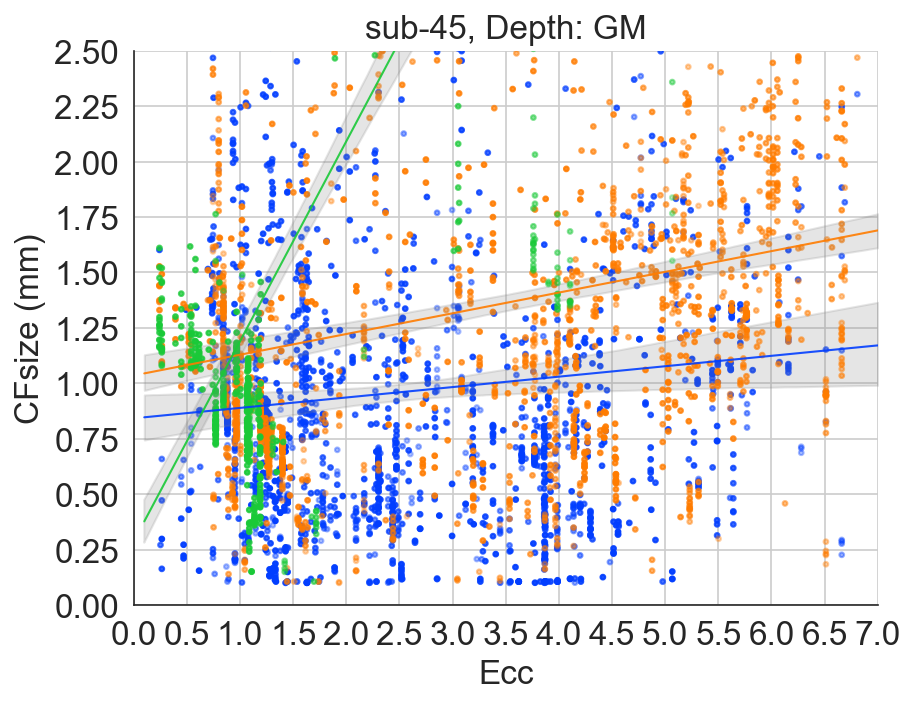

In [ ]:
for s in range(SUBJECTS.__len__()):
    thickness=[]
    skip_subject = False
    for roi in range(target_list.__len__()):
        print(roi)
        mask_CFmodel(SUBJECTS[s].rois[roi].CFmodel,depth_list,r2_thr, ecc_bound, CFsize_bound)
        for d in range(depth_list.__len__()):
            ecc=SUBJECTS[s].rois[roi].CFmodel[d].CFcenter_ecc
            size=SUBJECTS[s].rois[roi].CFmodel[d].CFsize
            r2=SUBJECTS[s].rois[roi].CFmodel[d].r2
            print(ecc.__len__())
            if ecc.__len__()>20:
                try:
                    SUBJECTS[s].rois[roi].curve[d],SUBJECTS[s].rois[roi].curve_low[d],SUBJECTS[s].rois[roi].curve_up[d] = bs_scatter2weightedavg(ecc, size, r2, 2000, 0.95,ecc_bound,pred_point)
                except Exception as e:
                    print(f"Error in bs_scatter2weightedavg for Subject {subjectid[s]}, ROI {rois_list[0][roi]}, Depth {depth_list[d]}: {e}")
                    SUBJECTS[s].rois[roi].curve[d] = None
                    SUBJECTS[s].rois[roi].curve_low[d] = None
                    SUBJECTS[s].rois[roi].curve_up[d] = None
                    continue
            else:
                    SUBJECTS[s].rois[roi].curve[d] = None
                    SUBJECTS[s].rois[roi].curve_low[d] = None
                    SUBJECTS[s].rois[roi].curve_up[d] = None
                    #skip_subject=True
                    #break
            if skip_subject==True:
                break
            if depth_list[d]!='GM':
               dag_add_ax_basics(plt.gca(), xlabel='Eccentricity (deg)', ylabel='CFsize (mm)',title=f'{subjectid[s]}, {rois_list[0][roi]}, Depth: {str(float(depth_list[d])*100+6.25)}%')
            else:
                dag_add_ax_basics(plt.gca(), xlabel='Ecc', ylabel='CFsize (mm)',title=f'{subjectid[s]}, Depth: {str(depth_list[d])}')
            dag_update_ax_fontsize(plt.gca(), 16)
            dag_update_ax_dotsize(plt.gca(), 5)
            plt.xlim(0,ecc_bound[1]),
            plt.ylim([0,CFsize_bound[1]])
            try:
                print(rois_list[0][roi],np.nanmean(SUBJECTS[s].rois[roi].CFmodel[0].thickness))
            except:
                continue

    # Get the current figure and adjust its DPI
    fig = plt.gcf()
    plt.legend().remove()
    fig.set_dpi(150)
    plt.grid(True)
    plt.locator_params(axis='y', nbins=10)
    plt.locator_params(axis='x', nbins=10)
    plt.xticks(np.arange(0, ecc_bound[1] + 0.5, 0.5))
    #plt.show()
    #plt.plot(range(rois_list[0].__len__()),thickness)
    #plt.ylim([0,2.5])
    plt.show()

In [ ]:
# I am looking for around eight vertices 
roi_idx = 1  # V3
depth_idx = 0  

ecc = SUBJECTS[s].rois[roi_idx].CFmodel[depth_idx].CFcenter_ecc
cfsize = SUBJECTS[s].rois[roi_idx].CFmodel[depth_idx].CFsize
fs_idx = SUBJECTS[s].rois[roi_idx].CFmodel[depth_idx].fs_idx

ecc_mask = (ecc > 6.6) & (ecc < 7.0) # Mask eccentricity 
cfsize_mask = (cfsize > 1.0) & (cfsize < 1.3)  # Mask size 
combined_mask = ecc_mask & cfsize_mask
selected_vertices = fs_idx[combined_mask] # Get only the ones in the mask

print("Vertex indices:", selected_vertices)

import os

# Setup
hemi = 'rh'  # or 'rh', depending on the hemisphere
subject_fs = subjectid[s]  
label_name = 'V3RAINY'
label_dir = os.path.join(fs_dirPATH, subject_fs, 'label')
os.makedirs(label_dir, exist_ok=True)
label_path = os.path.join(label_dir, f'{hemi}.V3RAINY.label')

# Get vertex indices
vertices = selected_vertices  # from earlier mask
vertices = vertices.astype(int)

# Load surface coordinates (to fill label properly)
coords, _ = cortex.db.get_surf(subject_fs, "fiducial", hemi)
# Note: make sure coords.shape[0] matches the FS vertex count

# Write label file
with open(label_path, 'w') as f:
    f.write('#!ascii label file\n')
    f.write(f'{len(vertices)}\n')
    for idx in vertices:
        x, y, z = coords[idx]
        f.write(f'{idx} {x:.5f} {y:.5f} {z:.5f} 1.0\n')  # 1.0 is the "stat" value

Vertex indices: [ 12373 100560  13325  13326  12375  13327 109298  12363 109877  12344
  16195  15206]
